In [ ]:
#Installation
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

#spark
import findspark
findspark.init()

In [ ]:
#Creating Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LoanApprovedUsingPyspark").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Loan Application Approval/loan.csv", header=True, inferSchema=True)
data.show(10)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [ ]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|    13|      3|        15|        0|           32|              0|                0|        22|              14|            50|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



array([[<Axes: title={'center': 'LoanAmount_log'}>]], dtype=object)

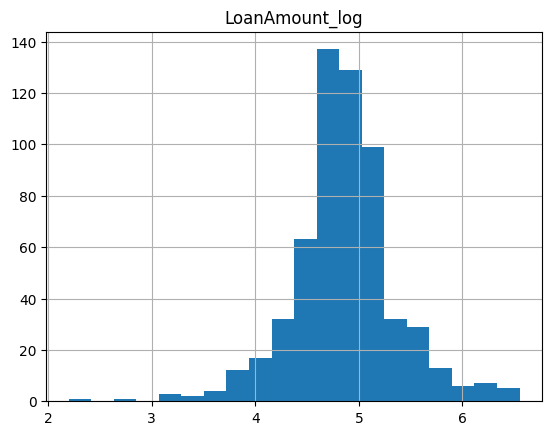

In [ ]:
#adds a new column named "LoanAmount_log" to the PySpark DataFrame, where each value is the logarithm of the corresponding "LoanAmount" value.
#converts the PySpark DataFrame to a Pandas DataFrame for plotting the histogram in a notebook environment using the hist method.


from pyspark.sql.functions import col, log
data = data.withColumn("LoanAmount_log", log(col("LoanAmount")))
data.select("LoanAmount_log").toPandas().hist(column="LoanAmount_log", bins=20)

array([[<Axes: title={'center': 'TotalIncome_log'}>]], dtype=object)

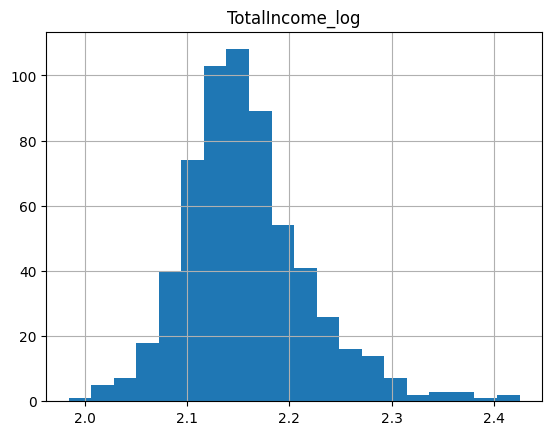

In [ ]:
#"TotalIncome": Represents the logarithm of the sum of "ApplicantIncome" and "CoapplicantIncome."
#"TotalIncome_log": Represents the logarithm of the "TotalIncome" column.
#Plots a histogram of the "TotalIncome_log" column with 20 bins.

data = data.withColumn("TotalIncome", log(col("ApplicantIncome") + col("CoapplicantIncome")))
data = data.withColumn("TotalIncome_log", log(col("TotalIncome")))
data.select("TotalIncome_log").toPandas().hist(column="TotalIncome_log", bins=20)

In [ ]:
colNames = data.columns
colNames

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status',
 'LoanAmount_log',
 'TotalIncome',
 'TotalIncome_log']

**Exploratory Data Analysis**

In [ ]:

from pyspark.sql.functions import mean, when, col, isnan, count

#calculates the mode by grouping the data by that column, counting occurrences, and ordering in descending order.
#It then fills missing values in the column with the calculated mode using the withColumn and when functions.Categorical column deals with 0

columns_to_fill_mode = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
for column in columns_to_fill_mode:
    mode_value = data.groupBy(column).count().orderBy("count", ascending=False).first()[column]
    data = data.withColumn(column, when(col(column).isNull(), mode_value).otherwise(col(column)))

# Fill missing values for numerical columns with mean
#Filling missing values with the mean is a straightforward method for numerical columns.
columns_to_fill_mean = ['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','LoanAmount_log','TotalIncome','TotalIncome_log']
for column in columns_to_fill_mean:
    mean_value = data.select(mean(column)).collect()[0][0]
    data = data.withColumn(column, when(col(column).isNull(), mean_value).otherwise(col(column)))

# Show the count of null values after imputation
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()


+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+--------------+-----------+---------------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|LoanAmount_log|TotalIncome|TotalIncome_log|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+--------------+-----------+---------------+
|      0|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|          0|             0|          0|              0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+--------------

In [ ]:
data.show(10)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------------+------------------+------------------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|        LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|   LoanAmount_log|       TotalIncome|   TotalIncome_log|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------------+------------------+------------------+
|LP001002|  Male|     No|         0|    Graduate|           No|         5849.0|              0.0|146.41216216216216|           360.0|           1.0|        Urban|          Y|4.857444178729353| 8.674025985443025| 2.160333041194141|
|LP001003|  Male|    Yes|         1|    Graduate|           No|         4583

In [ ]:
#Summarizing key information of the selected columns (describe() method can also be used)
data.select('Gender','Dependents','Education','Self_Employed','ApplicantIncome','LoanAmount',
            'Credit_History','Property_Area','TotalIncome','Loan_Status').summary().show()

+-------+------+------------------+------------+-------------+-----------------+------------------+------------------+-------------+------------------+-----------+
|summary|Gender|        Dependents|   Education|Self_Employed|  ApplicantIncome|        LoanAmount|    Credit_History|Property_Area|       TotalIncome|Loan_Status|
+-------+------+------------------+------------+-------------+-----------------+------------------+------------------+-------------+------------------+-----------+
|  count|   614|               614|         614|          614|              614|               614|               614|          614|               614|        614|
|   mean|  null|0.5399644760213144|        null|         null|5403.459283387622|146.41216216216213|0.8421985815602844|         null| 8.669413562902252|       null|
| stddev|  null| 0.779920152051259|        null|         null|6109.041673387181|  84.0374676831965|0.3496809866561487|         null|0.5451015367192202|       null|
|    min|Female|

In [ ]:
data.groupBy('Loan_Status').count().show()

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          Y|  422|
|          N|  192|
+-----------+-----+



In [ ]:

#Grouping a column and finding information about each group (continuous variables)
data.groupBy('Loan_Status').mean('Credit_History','TotalIncome').show()

+-----------+-------------------+-----------------+
|Loan_Status|avg(Credit_History)| avg(TotalIncome)|
+-----------+-------------------+-----------------+
|          Y| 0.9695766528856181|8.672073444078029|
|          N| 0.5622321956264774| 8.66356736573465|
+-----------+-------------------+-----------------+



In [ ]:
#Grouping a column and finding information about each group (continuous variables)
data.groupBy('Loan_Status').mean('LoanAmount').show()

+-----------+------------------+
|Loan_Status|   avg(LoanAmount)|
+-----------+------------------+
|          Y|144.34960612271036|
|          N|150.94548845720723|
+-----------+------------------+



In [ ]:
#Grouping a column based on categories of data present there (categorial variable)
data.groupBy('Loan_Status').pivot('Education').count().show()

+-----------+--------+------------+
|Loan_Status|Graduate|Not Graduate|
+-----------+--------+------------+
|          Y|     340|          82|
|          N|     140|          52|
+-----------+--------+------------+



In [ ]:

data.groupBy('Loan_Status').pivot('Self_Employed').count().show()

+-----------+---+---+
|Loan_Status| No|Yes|
+-----------+---+---+
|          Y|366| 56|
|          N|166| 26|
+-----------+---+---+



In [ ]:
data.groupBy('Loan_Status').pivot('Property_Area').count().show()

+-----------+-----+---------+-----+
|Loan_Status|Rural|Semiurban|Urban|
+-----------+-----+---------+-----+
|          Y|  110|      179|  133|
|          N|   69|       54|   69|
+-----------+-----+---------+-----+



In [ ]:
colNames = data.columns
colNames

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status',
 'LoanAmount_log',
 'TotalIncome',
 'TotalIncome_log']

In [ ]:
from pyspark.sql.functions import col
selected_columns_indices = list(range(1,2))+list(range(3,6))+list(range(8,9))+list(range(10, 12))+list(range(14,15))

# Select columns using select method
selected_columns = [col(data.columns[i]) for i in selected_columns_indices]
selected_columns.append(col(data.columns[12]))  # Adding the target column

# Create a new DataFrame with selected columns
selected_df = data.select(*selected_columns)

# Show the resulting DataFrame
selected_df.show(10)


+------+----------+------------+-------------+------------------+--------------+-------------+------------------+-----------+
|Gender|Dependents|   Education|Self_Employed|        LoanAmount|Credit_History|Property_Area|       TotalIncome|Loan_Status|
+------+----------+------------+-------------+------------------+--------------+-------------+------------------+-----------+
|  Male|         0|    Graduate|           No|146.41216216216216|           1.0|        Urban| 8.674025985443025|          Y|
|  Male|         1|    Graduate|           No|             128.0|           1.0|        Rural| 8.714567550836485|          N|
|  Male|         0|    Graduate|          Yes|              66.0|           1.0|        Urban| 8.006367567650246|          Y|
|  Male|         0|Not Graduate|           No|             120.0|           1.0|        Urban|  8.50532301884575|          Y|
|  Male|         0|    Graduate|           No|             141.0|           1.0|        Urban| 8.699514748210191|     

In [ ]:
from pyspark.sql.functions import col
column_name = 'TotalIncome'

# Calculate the percentage of missing values
missing_percentage = (data.filter(col(column_name).isNull()).count() / data.count()) * 100
print("Percentage of missing {} is {:.2f}%".format(column_name, missing_percentage))


Percentage of missing TotalIncome is 0.00%


+------+-----+
|Gender|count|
+------+-----+
|Female|  112|
|  Male|  502|
+------+-----+



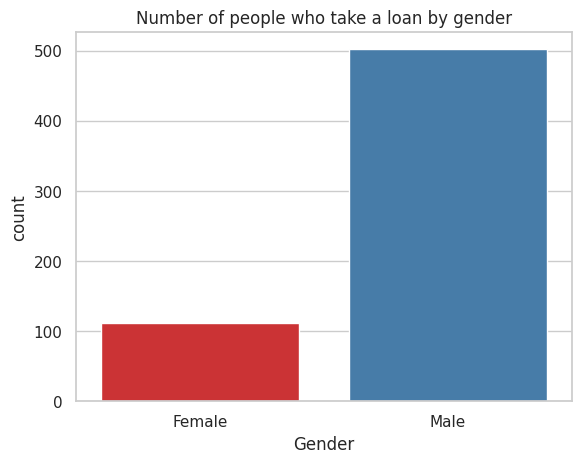

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
gender_counts = data.groupBy('Gender').count()
gender_counts.show()

# Convert PySpark DataFrame to Pandas DataFrame for plotting
gender_counts_pandas = gender_counts.toPandas()

# Plot the result using seaborn
sns.set(style="whitegrid")
sns.barplot(x='Gender', y='count', data=gender_counts_pandas, palette='Set1')
plt.title('Number of people who take a loan by gender')
plt.show()


+----------+-----+
|Dependents|count|
+----------+-----+
|         0|  360|
|         1|  102|
|        3+|   51|
|         2|  101|
+----------+-----+



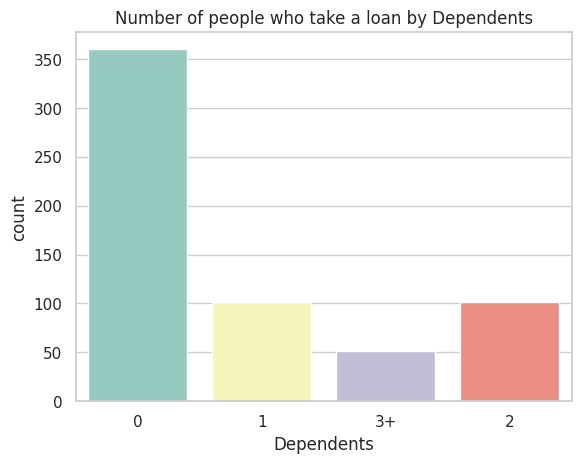

In [ ]:
depentCount = data.groupBy('Dependents').count()
depentCount.show()

# Convert PySpark DataFrame to Pandas DataFrame for plotting
depentCount_pandas = depentCount.toPandas()

# Plot the result using seaborn
sns.set(style="whitegrid")
sns.barplot(x='Dependents', y='count', data=depentCount_pandas, palette='Set3')
plt.title('Number of people who take a loan by Dependents')
plt.show()

+----------+-----+
|LoanAmount|count|
+----------+-----+
|     496.0|    1|
|     184.0|    2|
|     170.0|    3|
|     160.0|   12|
|      70.0|    8|
|      67.0|    3|
|     311.0|    1|
|     168.0|    3|
|     650.0|    1|
|     142.0|    1|
|     191.0|    1|
|     112.0|    8|
|     154.0|    2|
|     124.0|    5|
|     253.0|    1|
|     128.0|   11|
|     201.0|    2|
|     180.0|    6|
|     108.0|    5|
|     255.0|    3|
+----------+-----+
only showing top 20 rows



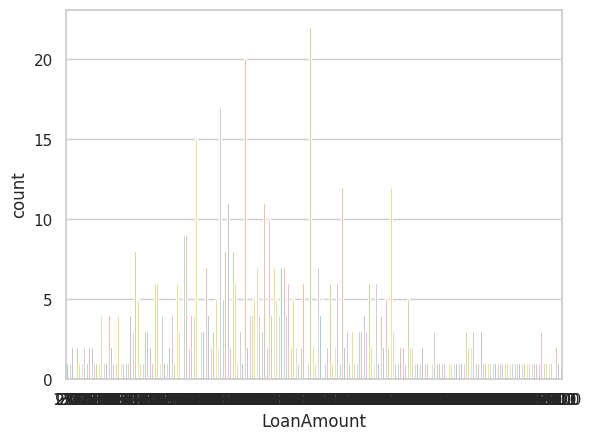

In [ ]:
loanCount = data.groupBy('LoanAmount').count()
loanCount.show()
loanCount_pandas = loanCount.toPandas()
# Plot the result using seaborn
sns.set(style="whitegrid")
sns.barplot(x='LoanAmount', y='count', data=loanCount_pandas, palette='Set2')
plt.show()

In [ ]:
# importing required libraries
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression,\
                    RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer

In [ ]:
data.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------------+-----------------+------------------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|        LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|   LoanAmount_log|      TotalIncome|   TotalIncome_log|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------------+-----------------+------------------+
|LP001002|  Male|     No|         0|    Graduate|           No|         5849.0|              0.0|146.41216216216216|           360.0|           1.0|        Urban|          Y|4.857444178729353|8.674025985443025| 2.160333041194141|
|LP001003|  Male|    Yes|         1|    Graduate|           No|         4583.0| 

In [ ]:
# ei comment kora doi cell e loan status re encoded kora hoy nai

#Converting categorical values to integer values (encoding)
#stringIndex = StringIndexer(inputCols=['Gender','Married','Education','Self_Employed','Dependents'],
 #                      outputCols=['Gender_','Married_','Education_','Self_Employed_','Dependents_'])

#stringIndex_model = stringIndex.fit(data)

#df1_ = stringIndex_model.transform(data).drop('Gender','Married','Education','Self_Employed','Dependents')
#df1_.show(4)

In [ ]:

#vec_asmbl = VectorAssembler(inputCols=df1_.columns[11:16],
#                          outputCol='features')

#df1_ = vec_asmbl.transform(df1_).select('features', 'Loan_Status')
#df1_.show(4, truncate=False)


In [ ]:
#Converting categorical values to integer values (encoding)
stringIndex = StringIndexer(inputCols=['Gender','Dependents','Education','Self_Employed','Property_Area','Loan_Status'],
                       outputCols=['Gender_','Dependents_','Education_','Self_Employed_','Property_Area_','Loan_Status_'])

stringIndex_model = stringIndex.fit(data)

df1_ = stringIndex_model.transform(data).drop('Gender','Dependents','Education','Self_Employed','Property_Area','Loan_Status')
df1_.show(4)

+--------+-------+---------------+-----------------+------------------+----------------+--------------+-----------------+-----------------+------------------+------------+-------+-----------+--------------+----------+--------------+
| Loan_ID|Married|ApplicantIncome|CoapplicantIncome|        LoanAmount|Loan_Amount_Term|Credit_History|   LoanAmount_log|      TotalIncome|   TotalIncome_log|Loan_Status_|Gender_|Dependents_|Property_Area_|Education_|Self_Employed_|
+--------+-------+---------------+-----------------+------------------+----------------+--------------+-----------------+-----------------+------------------+------------+-------+-----------+--------------+----------+--------------+
|LP001002|     No|         5849.0|              0.0|146.41216216216216|           360.0|           1.0|4.857444178729353|8.674025985443025| 2.160333041194141|         0.0|    0.0|        0.0|           1.0|       0.0|           0.0|
|LP001003|    Yes|         4583.0|           1508.0|             128

In [ ]:
colNames = df1_.columns
colNames

['Loan_ID',
 'Married',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'LoanAmount_log',
 'TotalIncome',
 'TotalIncome_log',
 'Loan_Status_',
 'Gender_',
 'Dependents_',
 'Property_Area_',
 'Education_',
 'Self_Employed_']

In [ ]:
vec_asmbl = VectorAssembler(inputCols= df1_.columns[11:16]+df1_.columns[4:5]+df1_.columns[6:7]+df1_.columns[8:9],
                           outputCol='features')

df1_ = vec_asmbl.transform(df1_).select('features', 'Loan_Status_')
df1_.show(7, truncate=False)

+------------------------------------------------------------+------------+
|features                                                    |Loan_Status_|
+------------------------------------------------------------+------------+
|(8,[2,5,6,7],[1.0,146.41216216216216,1.0,8.674025985443025])|0.0         |
|[0.0,1.0,2.0,0.0,0.0,128.0,1.0,8.714567550836485]           |1.0         |
|[0.0,0.0,1.0,0.0,1.0,66.0,1.0,8.006367567650246]            |0.0         |
|[0.0,0.0,1.0,1.0,0.0,120.0,1.0,8.50532301884575]            |0.0         |
|(8,[2,5,6,7],[1.0,141.0,1.0,8.699514748210191])             |0.0         |
|[0.0,2.0,1.0,0.0,1.0,267.0,1.0,9.170871628065816]           |0.0         |
|[0.0,0.0,1.0,1.0,0.0,95.0,1.0,8.255568653283746]            |0.0         |
+------------------------------------------------------------+------------+
only showing top 7 rows



In [ ]:
# Creating train and validation set
train_df, valid_df = df1_.randomSplit([0.8, 0.2])

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='Loan_Status_',
                                          metricName='accuracy')

In [ ]:
#Ridge Regression model
ridge = LogisticRegression(labelCol='Loan_Status_',
                        maxIter=100,
                        elasticNetParam=0,
                        regParam=0.03)

model = ridge.fit(train_df)
pred = model.transform(valid_df)
evaluator.evaluate(pred)

0.8484848484848485

In [ ]:
#Lasso Regression model
lasso = LogisticRegression(labelCol='Loan_Status_',
                           maxIter=100,
                           elasticNetParam=1,
                           regParam=0.0003)

model = lasso.fit(train_df)
pred = model.transform(valid_df)
evaluator.evaluate(pred)

0.8484848484848485

In [ ]:
#Random Forest Classifier Model
rf = RandomForestClassifier(labelCol='Loan_Status_',
                           numTrees=100, maxDepth=3)

model = rf.fit(train_df)
pred = model.transform(valid_df)
evaluator.evaluate(pred)

0.8484848484848485

In [ ]:
#Gradient Boosting Classifier
gb = GBTClassifier(labelCol='Loan_Status_', maxIter=100, maxDepth=3)

model = gb.fit(train_df)
pred = model.transform(valid_df)
evaluator.evaluate(pred)

0.8409090909090909

In [ ]:
#Creating pipelne
pipeline_rf = Pipeline(stages=[stringIndex, vec_asmbl, rf])

#Creating Grid
paramGrid = ParamGridBuilder().\
            addGrid(rf.maxDepth, [3, 4, 5]).\
            addGrid(rf.minInfoGain, [0.001, 0.01, 0.1]).\
            addGrid(rf.numTrees, [100,500,1000]).\
            build()

#Initializing crossvalidator
selected_model = CrossValidator(estimator=pipeline_rf,
                                estimatorParamMaps=paramGrid,
                                evaluator=evaluator,
                                numFolds=5)

model_final = selected_model.fit(data)
pred_train = model_final.transform(data)
evaluator.evaluate(pred_train)

0.8094462540716613